# Compute tech. potential and sanity-check load shapes
### First make sure to update dr-path local.py file to reflect region and path to database

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from dr_path.db import models, io
from dr_path import settings
#%matplotlib notebook

In [2]:
#Open database
outdir = '/mnt/g/Shared drives\BTO Topic 2  Integrating EE & DR\Task 2\Load_Shape_Data\ACEEE load\Paper results'.replace('\\','/')
#Close the DB if it's open
try:
    models.database.close()
except:
    pass

db_file = settings.DB_NAME
models.database.init(db_file)

models.database.connect()

print(outdir)

/mnt/g/Shared drives/BTO Topic 2  Integrating EE & DR/Task 2/Load_Shape_Data/ACEEE load/Paper results


In [3]:
#Get a dataframe of dr features for each modeled cluster of buildings. 
#These are the cluster load shape features (or clsf for short)

clsf = io.modelselect2dataframe(models.CLSFeature.select(
            models.CLSFeature.value, 
            models.Cluster.name.alias('cluster'),
            models.Cluster.region, 
            models.Cluster.building_type,
            models.Cluster.customer_count,
            models.EndUse.name.alias('end_use'),
            models.DemandScenario.name.alias('demand_scenario')).join(
                models.ClusterLoadShape).join(models.Cluster).switch(
                models.ClusterLoadShape).join(models.EndUse).switch(
                models.CLSFeature).join(models.DemandScenario).where(
                    (models.CLSFeature.dr_type=='shed') & (models.Cluster.sector=='res') &
                    ~(models.EndUse.name << ['battery', 'total'])))
#Map hvac back to cooling (need to fix this in dr-path)
clsf.loc[clsf['end_use']=='hvac', 'end_use']='cooling'

#The value column below represents the technical Shed DR potential for each cluster of buildings in each 
#EE demand scenario
clsf

value                                            cluster  \
0     0.030295            USA_CA_Arcata.725945_2016-Mobile_Home_0   
1     0.003231            USA_CA_Arcata.725945_2016-Mobile_Home_0   
2     0.027679            USA_CA_Arcata.725945_2016-Mobile_Home_0   
3     0.000245            USA_CA_Arcata.725945_2016-Mobile_Home_0   
4     0.145484            USA_CA_Arcata.725945_2016-Mobile_Home_0   
...        ...                                                ...   
3661  0.375183  USA_NV_Reno.Cannon.Intl.724880_2016-Single-Fam...   
3662  0.014423  USA_NV_Reno.Cannon.Intl.724880_2016-Single-Fam...   
3663  0.162119  USA_NV_Reno.Cannon.Intl.724880_2016-Single-Fam...   
3664  0.002783  USA_NV_Reno.Cannon.Intl.724880_2016-Single-Fam...   
3665  0.097694  USA_NV_Reno.Cannon.Intl.724880_2016-Single-Fam...   

                       region           building_type  customer_count  \
0               USA_CA_Arcata             Mobile Home             126   
1               USA_CA_Arcata             Mobile Home             126   
2               USA_CA_Arcata             Mobile Home             126   
3               USA_CA_Arcata             Mobile Home             126   
4               USA_CA_Arcata             Mobile Home             126   
...                       ...                     ...             ...   
3661  USA_NV_Reno.Cannon.Intl  Single-Family Detached           46135   
3662  USA_NV_Reno.Cannon.Intl  Single-Family Detached           46135   
3663  USA_NV_Reno.Cannon.Intl  Single-Family Detached           46135   
3664  USA_NV_Reno.Cannon.Intl  Single-Family Detached           46135   
3665  USA_NV_Reno.Cannon.Intl  Single-Family Detached           46135   

             end_use              demand_scenario  
0      clothes_dryer  BaseDemand_upgrade3_2016AMY  
1     clothes_washer  BaseDemand_upgrade3_2016AMY  
2         dishwasher  BaseDemand_upgrade3_2016AMY  
3            heating  BaseDemand_upgrade3_2016AMY  
4            cooling  BaseDemand_upgrade3_2016AMY  
...              ...                          ...  
3661      plug_loads  BaseDemand_upgrade0_2016AMY  
3662       pool_pump  BaseDemand_upgrade0_2016AMY  
3663   refrigeration  BaseDemand_upgrade0_2016AMY  
3664     ventilation  BaseDemand_upgrade0_2016AMY  
3665   water_heating  BaseDemand_upgrade0_2016AMY  

[3666 rows x 7 columns]

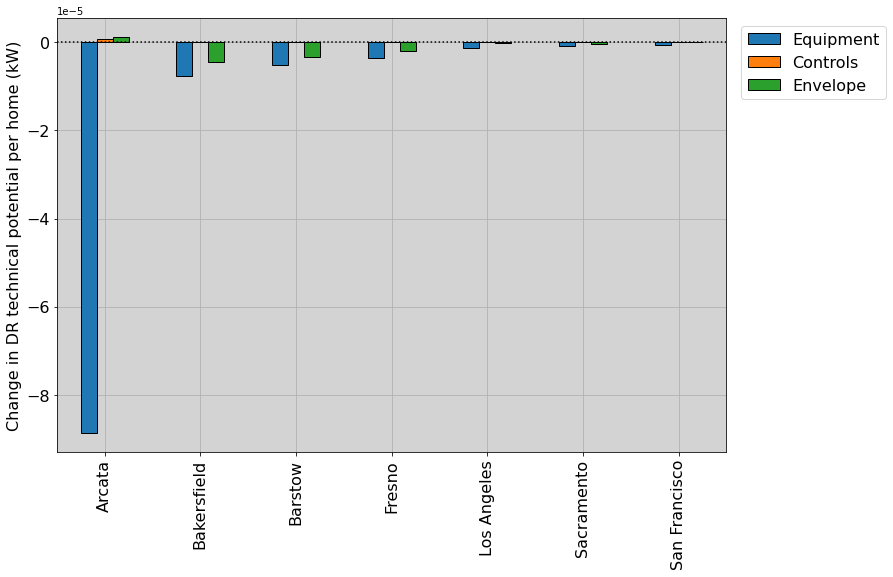

In [4]:


#Create figure
fig,ax = plt.subplots(figsize=[12,8])

#Get list of demand scenarios
ds_list = clsf['demand_scenario'].unique()
ds_list.sort()
#create a map to reanme the demand scenarios
ds_name_map = dict(zip(ds_list,['Base','Equipment','Controls','Envelope','Cont.+Env.','All']))


#Parse city names
clsf['city'] = clsf['region'].str.split('_').str[2].str.split('.').str[0:2].str.join(' ').values

#That didn't work perfectly, so tweak by hand
city_tweak = {'Midland Midland':'Midland', 'Lubbock Lubbock':'Lubbock', 'Dallas Fort':'Dallas', 
              'Shreveport Regional':'Shreveport', 'Abilene Municipal':'Abilene', 
              'Amarillo Intl':'Amarillo',
              'Angelina Co':'Angelina', 'Austin Mueller':'Austin', 'Brownsville Intl':'Brownsville',
              'Houston Intercontin':'Houston',
              'Victoria Victoria':'Victoria', 'Waco Rgnl':'Waco', 
              'Barstow Daggett': 'Barstow', 'Bakersfield Meadows':'Bakersfield', 
              'Fresno Air':'Fresno', 'Reno Cannon':'Reno',
              'Sacramento Executiv': 'Sacramento'}

#Lists of cities to keep
if settings.REGION == 'CAMX':
    cities=['Arcata', 'Bakersfield', 'Barstow', 'Fresno', 
            'Los Angeles', 'Sacramento', 'San Francisco']
else:
    cities = ['Abilene','Amarillo','Brownsville', 'Corpus Christi',  
              'Dallas', 'Houston', 'Shreveport']

#Reshape data to plot building-level technical potential
clsf_sfd = clsf.loc[clsf['building_type']=='Single-Family Detached'].groupby(
    ['city', 'demand_scenario']).agg({'value':'sum', 'customer_count':'mean'})

#Compute potential per building and difference from baseline
clsf_sfd['value_bldg'] = clsf_sfd['value']/clsf_sfd['customer_count']
clsf_sfd['diff_bldg'] = 0
for c,d in clsf_sfd.index:
    clsf_sfd.loc[(c,d),'diff_bldg'] = clsf_sfd.loc[(c,d),'value_bldg'] - clsf_sfd.loc[(c,ds_list[0]),'value_bldg']
    

#Generate plot
plot_data = clsf_sfd['diff_bldg'].unstack().rename(
    index=city_tweak,
    columns=ds_name_map).reindex(cities)[
    ['Equipment','Controls', 'Envelope']]

ax.axhline(color='k', linestyle=':')
plot_data.plot(
    kind='bar', edgecolor='k', fontsize=16, grid=True,ax=ax, legend=False)

ax.set_axisbelow(True)
ax.set_facecolor("lightgray")
ax.set_ylabel('Change in DR technical potential per home (kW)', fontsize=16)
ax.set_xlabel('')
ax.legend(loc='upper left', bbox_to_anchor=[1.01,1], fontsize=16)
#plot_data.mul(0).plot(use_index=True, ax=ax, color='k', linestyle='-.', legend=False)
#clsf_sfd['diff_bldg'].plot(kind='bar', ax=ax)#['cluster'].iloc[1]
#clsf_sfd.loc[clsf['demand_scenario']==ds_list[0],'value']-clsf.loc[]

In [9]:
clsf_sfd

value  customer_count  \
city                demand_scenario                                         
Arcata              BaseDemand_upgrade0_2016AMY  1.235252            6151   
                    BaseDemand_upgrade1_2016AMY  0.690769            6151   
                    BaseDemand_upgrade2_2016AMY  1.239321            6151   
                    BaseDemand_upgrade3_2016AMY  1.241976            6151   
                    BaseDemand_upgrade4_2016AMY  1.247443            6151   
                    BaseDemand_upgrade5_2016AMY  0.690082            6151   
Bakersfield Meadows BaseDemand_upgrade0_2016AMY  2.684591          116431   
                    BaseDemand_upgrade1_2016AMY  1.790437          116431   
                    BaseDemand_upgrade2_2016AMY  2.683115          116431   
                    BaseDemand_upgrade3_2016AMY  2.166927          116431   
                    BaseDemand_upgrade4_2016AMY  2.181740          116431   
                    BaseDemand_upgrade5_2016AMY  1.392772          116431   
Barstow Daggett     BaseDemand_upgrade0_2016AMY  3.241928          198618   
                    BaseDemand_upgrade1_2016AMY  2.215821          198618   
                    BaseDemand_upgrade2_2016AMY  3.233507          198618   
                    BaseDemand_upgrade3_2016AMY  2.572073          198618   
                    BaseDemand_upgrade4_2016AMY  2.582845          198618   
                    BaseDemand_upgrade5_2016AMY  1.683536          198618   
Fresno Air          BaseDemand_upgrade0_2016AMY  2.636384          241387   
                    BaseDemand_upgrade1_2016AMY  1.784303          241387   
                    BaseDemand_upgrade2_2016AMY  2.639570          241387   
                    BaseDemand_upgrade3_2016AMY  2.144722          241387   
                    BaseDemand_upgrade4_2016AMY  2.161456          241387   
                    BaseDemand_upgrade5_2016AMY  1.398709          241387   
Long Beach          BaseDemand_upgrade0_2016AMY  1.892595         1510978   
                    BaseDemand_upgrade1_2016AMY  1.176111         1510978   
                    BaseDemand_upgrade2_2016AMY  1.907076         1510978   
                    BaseDemand_upgrade3_2016AMY  1.696097         1510978   
                    BaseDemand_upgrade4_2016AMY  1.723316         1510978   
                    BaseDemand_upgrade5_2016AMY  1.037898         1510978   
Los Angeles         BaseDemand_upgrade0_2016AMY  1.642423          451199   
                    BaseDemand_upgrade1_2016AMY  0.998936          451199   
                    BaseDemand_upgrade2_2016AMY  1.657306          451199   
                    BaseDemand_upgrade3_2016AMY  1.556209          451199   
                    BaseDemand_upgrade4_2016AMY  1.580657          451199   
                    BaseDemand_upgrade5_2016AMY  0.938379          451199   
Reno Cannon         BaseDemand_upgrade0_2016AMY  2.436040           46135   
                    BaseDemand_upgrade1_2016AMY  1.539924           46135   
                    BaseDemand_upgrade2_2016AMY  2.437699           46135   
                    BaseDemand_upgrade3_2016AMY  2.071758           46135   
                    BaseDemand_upgrade4_2016AMY  2.092842           46135   
                    BaseDemand_upgrade5_2016AMY  1.234192           46135   
Sacramento Executiv BaseDemand_upgrade0_2016AMY  2.178929          990680   
                    BaseDemand_upgrade1_2016AMY  1.406541          990680   
                    BaseDemand_upgrade2_2016AMY  2.190209          990680   
                    BaseDemand_upgrade3_2016AMY  1.822120          990680   
                    BaseDemand_upgrade4_2016AMY  1.844644          990680   
                    BaseDemand_upgrade5_2016AMY  1.143021          990680   
San Francisco       BaseDemand_upgrade0_2016AMY  1.194301          847603   
                    BaseDemand_upgrade1_2016AMY  0.678906          847603   
                    BaseDemand_upgrade2_2016AMY 

In [12]:
clsf['city'].unique()

array(['Arcata', 'Bakersfield Meadows', 'Barstow Daggett', 'Fresno Air',
       'Long Beach', 'Los Angeles', 'Sacramento Executiv',
       'San Francisco', 'Santa Maria', 'Reno Cannon'], dtype=object)

In [13]:
ds_list

array(['BaseDemand_upgrade0_2016AMY', 'BaseDemand_upgrade1_2016AMY',
       'BaseDemand_upgrade2_2016AMY', 'BaseDemand_upgrade3_2016AMY',
       'BaseDemand_upgrade4_2016AMY', 'BaseDemand_upgrade5_2016AMY'],
      dtype=object)

In [14]:
clus = io.modelselect2dataframe(models.Cluster.select(
    models.Cluster.name.alias('cluster'),
    models.DemandScenario.name.alias('demand_scenario'),
    models.Cluster.kwh_ann_tot).join(models.DemandScenario).where(
        models.Cluster.sector=='res'))
clus

cluster  \
0              USA_CA_Arcata.725945_2016-Mobile_Home_0   
1    USA_CA_Arcata.725945_2016-Multi-Family_with_2_...   
2    USA_CA_Arcata.725945_2016-Multi-Family_with_5+...   
3    USA_CA_Arcata.725945_2016-Single-Family_Detach...   
4    USA_CA_Bakersfield.Meadows.723840_2016-Mobile_...   
..                                                 ...   
277  USA_NV_Reno.Cannon.Intl.724880_2016-Mobile_Home_0   
278  USA_NV_Reno.Cannon.Intl.724880_2016-Multi-Fami...   
279  USA_NV_Reno.Cannon.Intl.724880_2016-Multi-Fami...   
280  USA_NV_Reno.Cannon.Intl.724880_2016-Single-Fam...   
281  USA_NV_Reno.Cannon.Intl.724880_2016-Single-Fam...   

                 demand_scenario   kwh_ann_tot  
0    BaseDemand_upgrade3_2016AMY   8026.634266  
1    BaseDemand_upgrade3_2016AMY   5978.262716  
2    BaseDemand_upgrade3_2016AMY   6407.124421  
3    BaseDemand_upgrade3_2016AMY   8638.980821  
4    BaseDemand_upgrade3_2016AMY  11802.536316  
..                           ...           ...  
277  BaseDemand_upgrade0_2016AMY  11190.335598  
278  BaseDemand_upgrade0_2016AMY   8078.266653  
279  BaseDemand_upgrade0_2016AMY   7763.905949  
280  BaseDemand_upgrade0_2016AMY   7944.994135  
281  BaseDemand_upgrade0_2016AMY  12485.166133  

[282 rows x 3 columns]

In [15]:
group2='end_use'
features = clsf.groupby(['demand_scenario',group2])['value'].sum().div(1.e6).unstack(0)
features.columns=('Base', 'Equipment','Controls','Envelope','Cont.+Env.', 'All')
#features.to_csv()
features

Base     Equipment      Controls      Envelope  \
end_use                                                                  
clothes_dryer   2.503427e-06  1.200750e-06  2.503427e-06  2.503427e-06   
clothes_washer  1.980811e-07  1.617250e-07  1.980811e-07  1.980811e-07   
cooling         2.851531e-05  2.080510e-05  2.867041e-05  2.208196e-05   
dishwasher      1.154197e-06  8.264641e-07  1.154197e-06  1.154197e-06   
heating         6.906091e-08  6.408625e-08  6.174267e-08  1.385984e-08   
hvac_fans       0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
lighting        1.217796e-05  5.274143e-06  1.217796e-05  1.217796e-05   
other           2.456451e-06  2.454472e-06  2.456451e-06  2.456451e-06   
plug_loads      1.519750e-05  7.598840e-06  1.519750e-05  1.519750e-05   
pool_pump       5.775179e-07  4.969388e-07  5.775179e-07  5.775179e-07   
refrigeration   7.505521e-06  6.174638e-06  7.505521e-06  7.505521e-06   
ventilation     1.081412e-07  1.081480e-07  1.081412e-07  1.081412e-07   
water_heating   1.948053e-06  8.632296e-07  1.948102e-06  1.948266e-06   

                  Cont.+Env.           All  
end_use                                     
clothes_dryer   2.503427e-06  1.200854e-06  
clothes_washer  1.980811e-07  1.617308e-07  
cooling         2.255027e-05  1.586530e-05  
dishwasher      1.154197e-06  8.265430e-07  
heating         1.307078e-08  3.781935e-08  
hvac_fans       0.000000e+00  0.000000e+00  
lighting        1.217796e-05  5.273723e-06  
other           2.456451e-06  2.454813e-06  
plug_loads      1.519750e-05  7.598873e-06  
pool_pump       5.775179e-07  4.970171e-07  
refrigeration   7.505521e-06  6.175013e-06  
ventilation     1.081412e-07  1.081425e-07  
water_heating   1.948052e-06  8.612667e-07

In [16]:
savings = clus.groupby('demand_scenario')['kwh_ann_tot'].sum()
savings = (savings/savings.iloc[0])
savings.index=('Base', 'Equipment','Controls','Envelope','Cont.+Env.', 'All')
savings=savings.reset_index()
savings

index  kwh_ann_tot
0        Base     1.000000
1   Equipment     0.551233
2    Controls     0.966638
3    Envelope     0.863609
4  Cont.+Env.     0.844564
5         All     0.470485

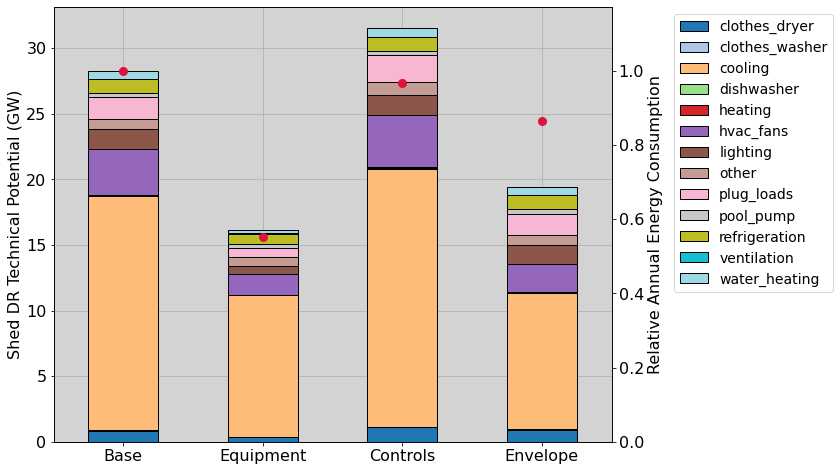

In [17]:
fig, ax = plt.subplots(figsize=(10,8))

plot_ports = ['Base', 'Equipment', 'Controls', 'Envelope', ]#'Cont.+Env.', 'All']

features[plot_ports].T.plot.bar(stacked=True, legend=False, cmap=plt.cm.get_cmap('tab20'), edgecolor='k', 
                    fontsize=16, grid=True,
                    ax=ax)
ax.set_axisbelow(True)
#ax.scatter(savings['index'], savings['kwh_ann_tot'], secondary_y=True)
savings.loc[savings['index'].isin(plot_ports)].plot(x='index', y='kwh_ann_tot', secondary_y=True, ax=ax, 
             marker='o', markersize=8, linestyle='', color='crimson', grid=True, fontsize=16)
ax.set_axisbelow(True)
ax.set_facecolor("lightgray")
ax.set_ylabel('Shed DR Technical Potential (GW)', fontsize=16)
ax.right_ax.set_ylabel('Relative Annual Energy Consumption', fontsize=16)
ax.set_xlabel(None)
yl = ax.get_ylim()
ax.right_ax.set_ylim([0, yl[1]/features['Base'].sum()])
ax.legend(loc='upper left', bbox_to_anchor=[1.1,1], fontsize=14)
#fig.savefig(os.path.join(outdir, ))

In [58]:
clsf.groupby(['demand_scenario','building_type'])['value'].sum().div(1.e6).unstack(0)

demand_scenario                BaseDemand_upgrade0_2016AMY  \
building_type                                                
Mobile Home                                       0.301141   
Multi-Family with 2 - 4 Units                     3.158998   
Multi-Family with 5+ Units                        2.167536   
Single-Family Attached                            0.116015   
Single-Family Detached                           10.107995   

demand_scenario                BaseDemand_upgrade1_2016AMY  \
building_type                                                
Mobile Home                                       0.238241   
Multi-Family with 2 - 4 Units                     2.073720   
Multi-Family with 5+ Units                        1.367481   
Single-Family Attached                            0.053578   
Single-Family Detached                            6.448021   

demand_scenario                BaseDemand_upgrade2_2016AMY  \
building_type                                                
Mobile Home                                       0.303279   
Multi-Family with 2 - 4 Units                     3.170399   
Multi-Family with 5+ Units                        2.203096   
Single-Family Attached                            0.118806   
Single-Family Detached                           10.298094   

demand_scenario                BaseDemand_upgrade3_2016AMY  \
building_type                                                
Mobile Home                                       0.235163   
Multi-Family with 2 - 4 Units                     3.059613   
Multi-Family with 5+ Units                        2.039704   
Single-Family Attached                            0.102354   
Single-Family Detached                            8.385580   

demand_scenario                BaseDemand_upgrade4_2016AMY  \
building_type                                                
Mobile Home                                       0.238876   
Multi-Family with 2 - 4 Units                     3.118019   
Multi-Family with 5+ Units                        2.096075   
Single-Family Attached                            0.111819   
Single-Family Detached                            8.599995   

demand_scenario                BaseDemand_upgrade5_2016AMY  
building_type                                               
Mobile Home                                       0.178757  
Multi-Family with 2 - 4 Units                     1.968577  
Multi-Family with 5+ Units                        1.239681  
Single-Family Attached                            0.051217  
Single-Family Detached                            5.009879

Index(['BaseDemand_upgrade0_2016AMY', 'BaseDemand_upgrade1_2016AMY',
       'BaseDemand_upgrade2_2016AMY', 'BaseDemand_upgrade3_2016AMY',
       'BaseDemand_upgrade4_2016AMY', 'BaseDemand_upgrade5_2016AMY'],
      dtype='object', name='demand_scenario')
Index(['BaseDemand_upgrade0_2016AMY', 'BaseDemand_upgrade1_2016AMY',
       'BaseDemand_upgrade2_2016AMY', 'BaseDemand_upgrade3_2016AMY',
       'BaseDemand_upgrade4_2016AMY', 'BaseDemand_upgrade5_2016AMY'],
      dtype='object', name='demand_scenario')
Index(['BaseDemand_upgrade0_2016AMY', 'BaseDemand_upgrade1_2016AMY',
       'BaseDemand_upgrade2_2016AMY', 'BaseDemand_upgrade3_2016AMY',
       'BaseDemand_upgrade4_2016AMY', 'BaseDemand_upgrade5_2016AMY'],
      dtype='object', name='demand_scenario')


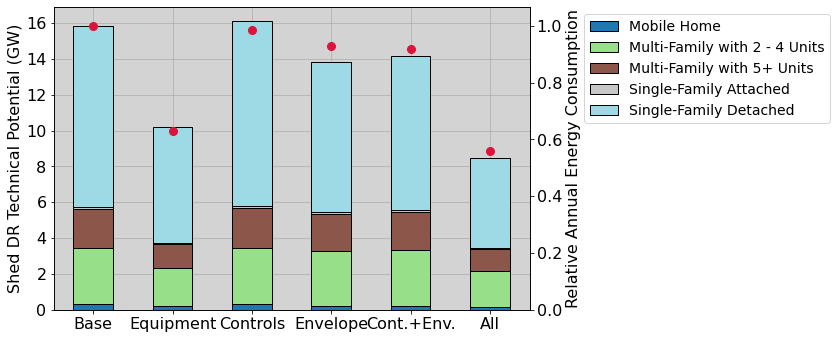

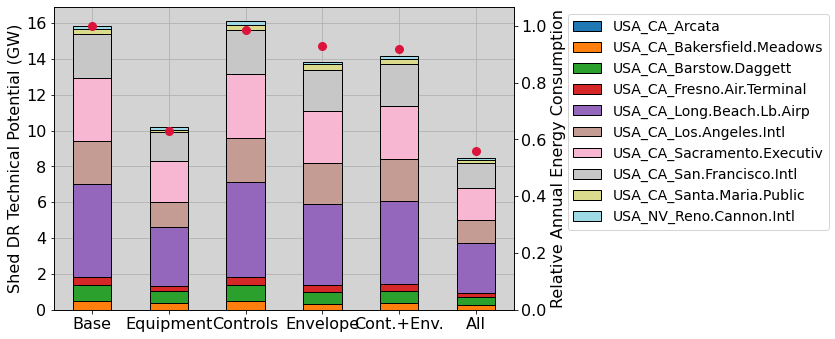

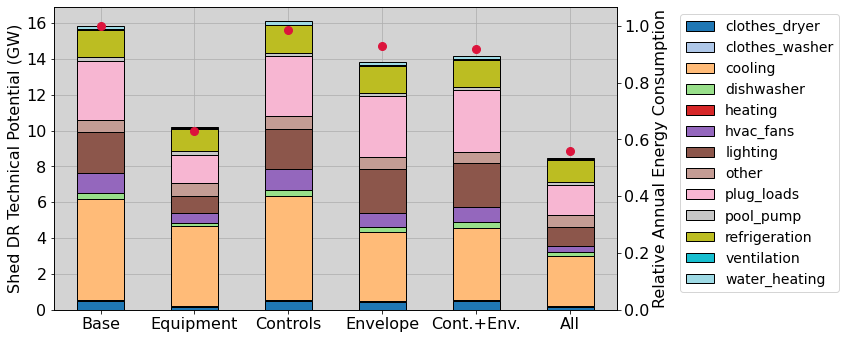

In [59]:
for group2 in ['building_type', 'region','end_use']:
    features = clsf.groupby(['demand_scenario',group2])['value'].sum().div(1.e6).unstack(0)
    print(features.columns)
    features.columns=('Base', 'Equipment','Controls','Envelope','Cont.+Env.', 'All')
    features.to_csv(os.path.join(outdir, 'features_agg_by_{g}_{r}.csv'.format(g=group2,
                                                                              r=settings.REGION)))

    fig, ax = plt.subplots(figsize=(12,5))
    features.T.plot.bar(stacked=True, legend=False, cmap=plt.cm.get_cmap('tab20'), edgecolor='k', 
                        fontsize=16, grid=True,
                        ax=ax)
    savings.plot(x='index', y='kwh_ann_tot', secondary_y=True, ax=ax, 
             marker='o', markersize=8, linestyle='', color='crimson', grid=True, fontsize=16)
    ax.set_axisbelow(True)
    ax.set_facecolor("lightgray")
    ax.set_ylabel('Shed DR Technical Potential (GW)', fontsize=16)
    ax.right_ax.set_ylabel('Relative Annual Energy Consumption', fontsize=16)
    ax.set_xlabel(None)
    yl = ax.get_ylim()
    ax.right_ax.set_ylim([0, yl[1]/features['Base'].sum()])
    ax.legend(loc='upper left', bbox_to_anchor=[1.1,1], fontsize=14)
    plt.tight_layout()
    fig.savefig(os.path.join(outdir,'features_agg_by_{g}_{r}.png'.format(g=group2,
                                                                         r=settings.REGION)),
                dpi=300)

## Before proceeding, stop here and re-run all of the above cells for each region.

### Next we generate a joint plot for all regions

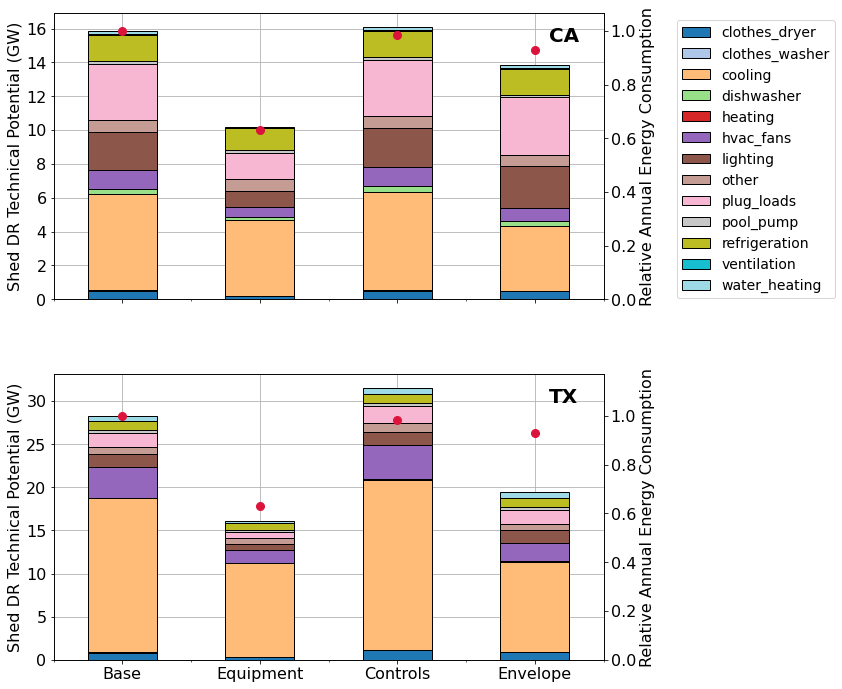

In [62]:
zero_env=False
fig, axs = plt.subplots(2,1, figsize=[12,10], sharex=True)
rs_map = {'CAMX':'CA', 'ERCT':'TX'}
for ax, reg in zip(axs, ['CAMX','ERCT']):
    features = pd.read_csv(os.path.join(outdir, 'features_agg_by_{g}_{r}.csv'.format(g='end_use',
                                                                                     r=reg)),
                          index_col='end_use')
    
    if (reg=='CAMX') & (zero_env):
        features[['Envelope', 'Cont.+Env.']]*= 0
    features[plot_ports].T.plot.bar(stacked=True, legend=False, cmap=plt.cm.get_cmap('tab20'), edgecolor='k', 
                        fontsize=16, grid=True,
                        ax=ax)
    savings.plot(x='index', y='kwh_ann_tot', secondary_y=True, ax=ax, legend=False, 
             marker='o', markersize=8, linestyle='', color='crimson', grid=True, fontsize=16)
    ax.set_axisbelow(True)
    ax.right_ax.set_ylabel('Relative Annual Energy Consumption', fontsize=16)
    ax.set_xlabel(None)
    yl = ax.get_ylim()
    ax.right_ax.set_ylim([0, yl[1]/features['Base'].sum()])
    #ax.set_facecolor("lightgray")
    ax.set_ylabel('Shed DR Technical Potential (GW)', fontsize=16)
    ax.text(0.9, 0.9, rs_map[reg], transform=ax.transAxes, fontsize=20, fontweight='bold')
axs[0].legend(loc='upper left', bbox_to_anchor=[1.12,1], fontsize=14)
#axs[1].legend(loc='upper left', bbox_to_anchor=[1.12,1], fontsize=14)
plt.tight_layout()
fig.savefig(os.path.join(outdir,'features_agg_by_{g}_{r}.png'.format(g='end_use',
                                                                     r='both')),
                dpi=300)



In [61]:
plt.cm.get_cmap('Set3')

## Check gross load shape
### (This can be skipped)

In [17]:
clusts = io.get_cluster_df(where=(models.Cluster.demand_scenario_id==1))
clusts

name     clustering_approach  \
id                                                                              
1   USA_CA_Arcata.725945_2016-Single-Family_Detach...  ResStockDryRun20200520   
2   USA_CA_Bakersfield.Meadows.723840_2016-Single-...  ResStockDryRun20200520   
3    USA_CA_Barstow.Daggett.723815_2016-Mobile_Home_0  ResStockDryRun20200520   
4   USA_CA_Barstow.Daggett.723815_2016-Single-Fami...  ResStockDryRun20200520   
5   USA_CA_Fresno.Air.Terminal.723890_2016-Single-...  ResStockDryRun20200520   
6   USA_CA_Long.Beach.Lb.Airp.722970_2016-Mobile_H...  ResStockDryRun20200520   
7   USA_CA_Long.Beach.Lb.Airp.722970_2016-Multi-Fa...  ResStockDryRun20200520   
8   USA_CA_Long.Beach.Lb.Airp.722970_2016-Multi-Fa...  ResStockDryRun20200520   
9   USA_CA_Long.Beach.Lb.Airp.722970_2016-Single-F...  ResStockDryRun20200520   
10  USA_CA_Long.Beach.Lb.Airp.722970_2016-Single-F...  ResStockDryRun20200520   
11  USA_CA_Los.Angeles.Intl.722950_2016-Multi-Fami...  ResStockDryRun20200520   
12  USA_CA_Los.Angeles.Intl.722950_2016-Multi-Fami...  ResStockDryRun20200520   
13  USA_CA_Los.Angeles.Intl.722950_2016-Single-Fam...  ResStockDryRun20200520   
14  USA_CA_Los.Angeles.Intl.722950_2016-Single-Fam...  ResStockDryRun20200520   
15  USA_CA_Sacramento.Executiv.724830_2016-Mobile_...  ResStockDryRun20200520   
16  USA_CA_Sacramento.Executiv.724830_2016-Multi-F...  ResStockDryRun20200520   
17  USA_CA_Sacramento.Executiv.724830_2016-Multi-F...  ResStockDryRun20200520   
18  USA_CA_Sacramento.Executiv.724830_2016-Single-...  ResStockDryRun20200520   
19  USA_CA_Sacramento.Executiv.724830_2016-Single-...  ResStockDryRun20200520   
20  USA_CA_San.Francisco.Intl.724940_2016-Mobile_H...  ResStockDryRun20200520   
21  USA_CA_San.Francisco.Intl.724940_2016-Multi-Fa...  ResStockDryRun20200520   
22  USA_CA_San.Francisco.Intl.724940_2016-Multi-Fa...  ResStockDryRun20200520   
23  USA_CA_San.Francisco.Intl.724940_2016-Single-F...  ResStockDryRun20200520   
24  USA_CA_San.Francisco.Intl.724940_2016-Single-F...  ResStockDryRun20200520   
25  USA_CA_Santa.Maria.Public.723940_2016-Single-F...  ResStockDryRun20200520   
26  USA_NV_Reno.Cannon.Intl.724880_2016-Single-Fam...  ResStockDryRun20200520   
27                                          com_other  ResStockDryRun20200520   
28                                          ind_other  ResStockDryRun20200520   

   sector                      region utility  customer_count  \
id                                                              
1     res               USA_CA_Arcata    CAMX            5763   
2     res  USA_CA_Bakersfield.Meadows    CAMX          117897   
3     res      USA_CA_Barstow.Daggett    CAMX           38968   
4     res      USA_CA_Barstow.Daggett    CAMX          209780   
5     res  USA_CA_Fresno.Air.Terminal    CAMX          249725   
6     res   USA_CA_Long.Beach.Lb.Airp    CAMX           84782   
7     res   USA_CA_Long.Beach.Lb.Airp    CAMX         1465553   
8     res   USA_CA_Long.Beach.Lb.Airp    CAMX          629952   
9     res   USA_CA_Long.Beach.Lb.Airp    CAMX            1339   
10    res   USA_CA_Long.Beach.Lb.Airp    CAMX         1444374   
11    res     USA_CA_Los.Angeles.Intl    CAMX          718479   
12    res     USA_CA_Los.Angeles.Intl    CAMX          706950   
13    res     USA_CA_Los.Angeles.Intl    CAMX             193   
14    res     USA_CA_Los.Angeles.Intl    CAMX          501253   
15    res  USA_CA_Sacramento.Executiv    CAMX           31228   
16    res  USA_CA_Sacramento.Executiv    CAMX          295096   
17    res  USA_CA_Sacramento.Executiv    CAMX          304891   
18    res  USA_CA_Sacramento.Executiv    CAMX           61884   
19    res  USA_CA_Sacramento.Executiv    CAMX         1038359   
20    res   USA_CA_San.Francisco.Intl    CAMX           10476   
21    res   USA_CA_San.Francisco.Intl    CAMX          747050   
22    res   USA_CA_San.Francisco.Intl    CAMX          539734   
23    res   USA_CA_San.Francisco.Intl    CAMX           44

In [18]:
tot_ls = io.get_load_shape_df(clusts.index, eu_names=['total'])
tot_ls

cluster             1              2             3              4   \
end_use          total          total         total          total   
loadshape          12             26            40             54    
0          3563.718183   70372.592471  24336.308683  151393.888132   
1          3349.223435   75715.638184  23861.387163  146191.723436   
2          3317.689283   71921.918260  24188.170420  147591.981539   
3          3333.408236   73988.718646  27023.341668  152647.435927   
4          3248.030297   73239.701679  24357.279660  154600.661069   
...                ...            ...           ...            ...   
8779       7663.151824  156260.377629  40646.473595  317870.917465   
8780       9134.700444  150929.631050  65956.526465  267990.952978   
8781       5848.603085  134190.421762  49624.973363  243202.709619   
8782       4699.546625  115427.010111  34843.388354  232198.405644   
8783       3921.318350   89858.964141  33068.055684  178324.704624   

cluster               5             6             7             8   \
end_use            total         total         total         total   
loadshape            68            82            96            110   
0          182493.681293  19713.900877  5.056597e+05  3.417499e+05   
1          169996.228791  17223.545468  4.625616e+05  2.536766e+05   
2          165500.473963  16108.833454  4.596640e+05  2.432764e+05   
3          165906.992264  15757.684903  4.586207e+05  2.370731e+05   
4          161880.191623  15344.059756  4.423646e+05  2.322569e+05   
...                  ...           ...           ...           ...   
8779       591447.654252  58766.524650  1.240392e+06  1.290676e+06   
8780       417673.541310  53857.915023  1.237869e+06  7.673306e+05   
8781       409854.380371  47601.015680  9.307004e+05  5.746841e+05   
8782       322706.422212  43324.808288  8.593113e+05  4.723628e+05   
8783       307745.534252  26908.972045  6.845892e+05  3.366341e+05   

cluster             9             10  ...            19            20  \
end_use          total         total  ...         total         total   
loadshape          124           138  ...           264           278   
0           534.042769  8.714333e+05  ...  1.870782e+06   7385.484682   
1           516.646644  9.511767e+05  ...  1.821960e+06   6866.938945   
2           506.932657  1.126433e+06  ...  1.934327e+06   6777.246240   
3           541.200748  1.249146e+06  ...  2.080531e+06   6681.180981   
4           558.784431  1.319767e+06  ...  2.173362e+06   6398.271526   
...                ...           ...  ...           ...           ...   
8779       1203.891418  2.518488e+06  ...  2.390657e+06  13884.670888   
8780       1137.964866  2.370292e+06  ...  2.318511e+06  13725.820702   
8781       1007.530274  2.140259e+06  ...  2.432378e+06  12732.375507   
8782        838.041353  2.184906e+06  ...  1.953694e+06  10563.556734   
8783        653.980376  1.633843e+06  ...  1.691142e+06   8523.541184   

cluster               21             22            23            24  \
end_use            total          total         total         total   
loadshape            292            306           320           334   
0          389355.420861  273914.463899  22207.963054  9.716244e+05   
1          366502.142172  270457.270573  21195.428115  9.314194e+05   
2          357955.171071  274534.115031  20665.341759  9.460821e+05   
3          355629.211662  284010.161791  20931.111770  9.970010e+05   
4          362788.828254  351266.087786  20956.032517  9.961431e+05   
...                  ...            ...           ...           ...   
8779       752220.607619  399676.290804  61681.321691  1.644039e+06   
8780       735269.000022  447901.489480  45925.897588  1.556337e+06   
8781       682741.863782  401075.859394  36746.310498  1.374979e+06   
8782       586780.969084  382732.970961  31189.660256  1.113985e+06   
8783       477829.141593  285353.541694  25726.596344  9.872899e+05   

cluster             

In [19]:
gls = pd.DataFrame(models.GrossLoadShape.get(id=1).hourly_kwh, index=range(1,8785))
gls

0
1     28929000.0
2     28117000.0
3     27229000.0
4     26570000.0
5     26267000.0
...          ...
8780  33034000.0
8781  31953000.0
8782  30737000.0
8783  29672000.0
8784  28627000.0

[8784 rows x 1 columns]

In [20]:
pd.DataFrame(tot_ls.sum(axis=1).values, index=range(1,8785))-gls

0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
...   ...
8780  0.0
8781  0.0
8782  0.0
8783  0.0
8784  0.0

[8784 rows x 1 columns]

In [66]:
#Read input data from Cong
in_data = pd.read_csv("/mnt/g/Shared drives/BTO Topic 2  Integrating EE & DR/Task 2/Load_Shape_Data/ACEEE load/ResStock result(Dry-run on 05 07 2020)/Gross_load_CA_scenario_0_vs_1.csv", index_col=None)

In [73]:
tot_ls
#From the dataframe below, pick the last two columns to compare, in order, below. These are the
#total commercial and Other load. We are just making sure they match the expected input values.

cluster             1              2             3              4   \
end_use          total          total         total          total   
loadshape          12             26            40             54    
0          3563.718183   70372.592471  24336.308683  151393.888132   
1          3349.223435   75715.638184  23861.387163  146191.723436   
2          3317.689283   71921.918260  24188.170420  147591.981539   
3          3333.408236   73988.718646  27023.341668  152647.435927   
4          3248.030297   73239.701679  24357.279660  154600.661069   
...                ...            ...           ...            ...   
8779       7663.151824  156260.377629  40646.473595  317870.917465   
8780       9134.700444  150929.631050  65956.526465  267990.952978   
8781       5848.603085  134190.421762  49624.973363  243202.709619   
8782       4699.546625  115427.010111  34843.388354  232198.405644   
8783       3921.318350   89858.964141  33068.055684  178324.704624   

cluster               5             6             7             8   \
end_use            total         total         total         total   
loadshape            68            82            96            110   
0          182493.681293  19713.900877  5.056597e+05  3.417499e+05   
1          169996.228791  17223.545468  4.625616e+05  2.536766e+05   
2          165500.473963  16108.833454  4.596640e+05  2.432764e+05   
3          165906.992264  15757.684903  4.586207e+05  2.370731e+05   
4          161880.191623  15344.059756  4.423646e+05  2.322569e+05   
...                  ...           ...           ...           ...   
8779       591447.654252  58766.524650  1.240392e+06  1.290676e+06   
8780       417673.541310  53857.915023  1.237869e+06  7.673306e+05   
8781       409854.380371  47601.015680  9.307004e+05  5.746841e+05   
8782       322706.422212  43324.808288  8.593113e+05  4.723628e+05   
8783       307745.534252  26908.972045  6.845892e+05  3.366341e+05   

cluster             9             10  ...            19            20  \
end_use          total         total  ...         total         total   
loadshape          124           138  ...           264           278   
0           534.042769  8.714333e+05  ...  1.870782e+06   7385.484682   
1           516.646644  9.511767e+05  ...  1.821960e+06   6866.938945   
2           506.932657  1.126433e+06  ...  1.934327e+06   6777.246240   
3           541.200748  1.249146e+06  ...  2.080531e+06   6681.180981   
4           558.784431  1.319767e+06  ...  2.173362e+06   6398.271526   
...                ...           ...  ...           ...           ...   
8779       1203.891418  2.518488e+06  ...  2.390657e+06  13884.670888   
8780       1137.964866  2.370292e+06  ...  2.318511e+06  13725.820702   
8781       1007.530274  2.140259e+06  ...  2.432378e+06  12732.375507   
8782        838.041353  2.184906e+06  ...  1.953694e+06  10563.556734   
8783        653.980376  1.633843e+06  ...  1.691142e+06   8523.541184   

cluster               21             22            23            24  \
end_use            total          total         total         total   
loadshape            292            306           320           334   
0          389355.420861  273914.463899  22207.963054  9.716244e+05   
1          366502.142172  270457.270573  21195.428115  9.314194e+05   
2          357955.171071  274534.115031  20665.341759  9.460821e+05   
3          355629.211662  284010.161791  20931.111770  9.970010e+05   
4          362788.828254  351266.087786  20956.032517  9.961431e+05   
...                  ...            ...           ...           ...   
8779       752220.607619  399676.290804  61681.321691  1.644039e+06   
8780       735269.000022  447901.489480  45925.897588  1.556337e+06   
8781       682741.863782  401075.859394  36746.310498  1.374979e+06   
8782       586780.969084  382732.970961  31189.660256  1.113985e+06   
8783       477829.141593  285353.541694  25726.596344  9.872899e+05   

cluster             

In [74]:
in_data['scaled_com_kwh']-tot_ls[27, 'total',366].values

0       0.000000e+00
1       0.000000e+00
2       0.000000e+00
3       0.000000e+00
4      -9.313226e-10
            ...     
8779    0.000000e+00
8780    0.000000e+00
8781    0.000000e+00
8782    0.000000e+00
8783    0.000000e+00
Name: scaled_com_kwh, Length: 8784, dtype: float64

In [75]:
in_data['scaled_other_load/KW']-tot_ls[28, 'total', 368].values

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
8779    0.0
8780    0.0
8781    0.0
8782    0.0
8783    0.0
Name: scaled_other_load/KW, Length: 8784, dtype: float64

In [18]:
models.database.close()

True